# Imports and Setup

# Progressive UNet for Medical Image Super-Resolution

Progressive multi-stage UNet architecture:
- **Stage 1:** Single UNet predicts i+2 (middle slice) from i and i+4
- **Stage 2:** Two UNets in parallel:
  - UNet2: Predicts i+1 from (i, i+2_generated)
  - UNet3: Predicts i+3 from (i+2_generated, i+4)

**Loss Strategy:** Multi-scale MSE loss from all three predictions (i+1, i+2, i+3) to compensate for vanishing gradients (Inception-style auxiliary losses)


In [1]:
import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import json
from datetime import datetime
import torch.nn.functional as F
import gc
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

# Add src directory to path
sys.path.append(os.path.join(os.getcwd(), 'src'))

# Check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"✅ Device: {DEVICE}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")


✅ Device: cuda
   GPU: NVIDIA B200
   Memory: 191.51 GB


In [2]:
# Setup path to access custom modules
root_directory = os.path.dirname(os.getcwd())
sys.path.append(os.path.join(root_directory, 'src'))

from ModelDataGenerator_ProgressiveUNet import build_progressive_dataloader


# Progressive UNet Architecture

In [3]:
class UNetBlock(nn.Module):
    """Basic UNet encoder/decoder block with convolution and skip connection support"""
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(UNetBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.conv(x)


class UNetStage(nn.Module):
    """
    Single UNet stage for Progressive UNet
    Input: 2 slices (e.g., i and i+4)
    Output: 1 slice prediction (e.g., i+2)
    """
    def __init__(self, in_channels=2, out_channels=1, base_features=64):
        super(UNetStage, self).__init__()
        
        # Encoder
        self.enc1 = UNetBlock(in_channels, base_features)
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.enc2 = UNetBlock(base_features, base_features * 2)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        self.enc3 = UNetBlock(base_features * 2, base_features * 4)
        self.pool3 = nn.MaxPool2d(2, 2)
        
        self.enc4 = UNetBlock(base_features * 4, base_features * 8)
        self.pool4 = nn.MaxPool2d(2, 2)
        
        # Bottleneck
        self.bottleneck = UNetBlock(base_features * 8, base_features * 16)
        
        # Decoder
        self.upconv4 = nn.ConvTranspose2d(base_features * 16, base_features * 8, kernel_size=2, stride=2)
        self.dec4 = UNetBlock(base_features * 16, base_features * 8)
        
        self.upconv3 = nn.ConvTranspose2d(base_features * 8, base_features * 4, kernel_size=2, stride=2)
        self.dec3 = UNetBlock(base_features * 8, base_features * 4)
        
        self.upconv2 = nn.ConvTranspose2d(base_features * 4, base_features * 2, kernel_size=2, stride=2)
        self.dec2 = UNetBlock(base_features * 4, base_features * 2)
        
        self.upconv1 = nn.ConvTranspose2d(base_features * 2, base_features, kernel_size=2, stride=2)
        self.dec1 = UNetBlock(base_features * 2, base_features)
        
        # Final output
        self.final = nn.Conv2d(base_features, out_channels, kernel_size=1)
    
    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        x = self.pool1(enc1)
        
        enc2 = self.enc2(x)
        x = self.pool2(enc2)
        
        enc3 = self.enc3(x)
        x = self.pool3(enc3)
        
        enc4 = self.enc4(x)
        x = self.pool4(enc4)
        
        # Bottleneck
        x = self.bottleneck(x)
        
        # Decoder with skip connections
        x = self.upconv4(x)
        x = torch.cat([x, enc4], dim=1)
        x = self.dec4(x)
        
        x = self.upconv3(x)
        x = torch.cat([x, enc3], dim=1)
        x = self.dec3(x)
        
        x = self.upconv2(x)
        x = torch.cat([x, enc2], dim=1)
        x = self.dec2(x)
        
        x = self.upconv1(x)
        x = torch.cat([x, enc1], dim=1)
        x = self.dec1(x)
        
        # Output
        x = self.final(x)
        
        return x


class ProgressiveUNet(nn.Module):
    """
    Progressive UNet with 3 stages:
    - Stage 1: UNet1(i, i+4) -> i+2_pred
    - Stage 2A: UNet2(i, i+2_pred) -> i+1_pred
    - Stage 2B: UNet3(i+2_pred, i+4) -> i+3_pred
    """
    def __init__(self, base_features=64):
        super(ProgressiveUNet, self).__init__()
        
        # Stage 1: Predict middle slice (i+2)
        self.unet1 = UNetStage(in_channels=2, out_channels=1, base_features=base_features)
        
        # Stage 2: Predict adjacent slices
        self.unet2 = UNetStage(in_channels=2, out_channels=1, base_features=base_features)  # (i, i+2) -> i+1
        self.unet3 = UNetStage(in_channels=2, out_channels=1, base_features=base_features)  # (i+2, i+4) -> i+3
    
    def forward(self, slices):
        """
        Input: slices of shape (B, 5, H, W)
            - slices[:, 0] = i
            - slices[:, 1] = i+1 (ground truth)
            - slices[:, 2] = i+2 (ground truth)
            - slices[:, 3] = i+3 (ground truth)
            - slices[:, 4] = i+4
        
        Returns:
            - pred_i2: Predicted i+2
            - pred_i1: Predicted i+1
            - pred_i3: Predicted i+3
        """
        batch_size = slices.shape[0]
        
        # Extract individual slices
        i = slices[:, 0:1, :, :]      # (B, 1, H, W)
        i_plus_1 = slices[:, 1:2, :, :]  # (B, 1, H, W)
        i_plus_2 = slices[:, 2:3, :, :]  # (B, 1, H, W)
        i_plus_3 = slices[:, 3:4, :, :]  # (B, 1, H, W)
        i_plus_4 = slices[:, 4:5, :, :]  # (B, 1, H, W)
        
        # Stage 1: Predict i+2 from (i, i+4)
        input_stage1 = torch.cat([i, i_plus_4], dim=1)  # (B, 2, H, W)
        pred_i_plus_2 = self.unet1(input_stage1)  # (B, 1, H, W)
        
        # Stage 2A: Predict i+1 from (i, predicted i+2)
        input_stage2a = torch.cat([i, pred_i_plus_2], dim=1)  # (B, 2, H, W)
        pred_i_plus_1 = self.unet2(input_stage2a)  # (B, 1, H, W)
        
        # Stage 2B: Predict i+3 from (predicted i+2, i+4)
        input_stage2b = torch.cat([pred_i_plus_2, i_plus_4], dim=1)  # (B, 2, H, W)
        pred_i_plus_3 = self.unet3(input_stage2b)  # (B, 1, H, W)
        
        return pred_i_plus_1, pred_i_plus_2, pred_i_plus_3

print("✅ Progressive UNet Architecture defined")


✅ Progressive UNet Architecture defined


# Multi-Scale Loss Function

In [4]:
class MultiScaleMSELoss(nn.Module):
    """
    Multi-scale MSE Loss for Progressive UNet
    Combines losses from all three predictions with different weights
    to compensate for vanishing gradient problem (Inception-style auxiliary losses)
    
    Loss = w1 * MSE(pred_i+1, gt_i+1) + 
           w2 * MSE(pred_i+2, gt_i+2) + 
           w3 * MSE(pred_i+3, gt_i+3)
    """
    def __init__(self, weights=None):
        super(MultiScaleMSELoss, self).__init__()
        
        # Default weights for auxiliary losses (higher weight for earlier/middle predictions)
        if weights is None:
            self.weights = {
                'w_i1': 0.5,   # i+1 prediction weight
                'w_i2': 1.0,   # i+2 prediction weight (main target)
                'w_i3': 0.5    # i+3 prediction weight
            }
        else:
            self.weights = weights
        
        self.mse_loss = nn.MSELoss()
    
    def forward(self, pred_i1, pred_i2, pred_i3, gt_i1, gt_i2, gt_i3):
        """
        Args:
            pred_i1, pred_i2, pred_i3: Predictions for i+1, i+2, i+3 (B, 1, H, W)
            gt_i1, gt_i2, gt_i3: Ground truth for i+1, i+2, i+3 (B, 1, H, W)
        
        Returns:
            Total weighted loss
        """
        loss_i1 = self.mse_loss(pred_i1, gt_i1)
        loss_i2 = self.mse_loss(pred_i2, gt_i2)
        loss_i3 = self.mse_loss(pred_i3, gt_i3)
        
        total_loss = (self.weights['w_i1'] * loss_i1 + 
                      self.weights['w_i2'] * loss_i2 + 
                      self.weights['w_i3'] * loss_i3)
        
        return total_loss, {
            'loss_i1': loss_i1.item(),
            'loss_i2': loss_i2.item(),
            'loss_i3': loss_i3.item(),
            'total_loss': total_loss.item()
        }

print("✅ Multi-Scale MSE Loss defined")


✅ Multi-Scale MSE Loss defined


# Load Data

In [5]:
# Configuration
BATCH_SIZE = 4
NUM_WORKERS = 4
AUGMENT = True

print(f"⚡ DATA CONFIGURATION:")
print(f"   BATCH_SIZE: {BATCH_SIZE}")
print(f"   NUM_WORKERS: {NUM_WORKERS}")
print(f"   AUGMENTATION: {AUGMENT}")

# Build dataloaders
train_loader = build_progressive_dataloader(
    split="train",
    batch_size=BATCH_SIZE,
    augment=AUGMENT,
    num_workers=NUM_WORKERS
)

val_loader = build_progressive_dataloader(
    split="val",
    batch_size=BATCH_SIZE,
    augment=False,
    num_workers=NUM_WORKERS
)

test_loader = build_progressive_dataloader(
    split="test",
    batch_size=BATCH_SIZE,
    augment=False,
    num_workers=NUM_WORKERS
)

print(f"\n✅ Data loaders created")
print(f"   Train: {len(train_loader)} batches")
print(f"   Val: {len(val_loader)} batches")
print(f"   Test: {len(test_loader)} batches")


⚡ DATA CONFIGURATION:
   BATCH_SIZE: 4
   NUM_WORKERS: 4
   AUGMENTATION: True

✅ Data loaders created
   Train: 8974 batches
   Val: 1582 batches
   Test: 2240 batches


# Training Configuration & Checkpoint Management

In [6]:
# Training Configuration
EPOCHS = 30
LEARNING_RATE = 5e-4
EARLY_STOPPING_PATIENCE = 5
MODEL_SAVE_DIR = Path('../models')
MODEL_SAVE_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_SAVE_DIR = Path('../results')
RESULTS_SAVE_DIR.mkdir(parents = True, exist_ok = True)

# Loss weights for multi-scale losses
LOSS_WEIGHTS = {
    'w_i1': 0.5,   # Weight for i+1 prediction
    'w_i2': 1.0,   # Weight for i+2 prediction (main)
    'w_i3': 0.5    # Weight for i+3 prediction
}

print("Training Configuration:")
print(f"   Epochs: {EPOCHS}")
print(f"   Learning Rate: {LEARNING_RATE}")
print(f"   Early stopping patience: {EARLY_STOPPING_PATIENCE}")
print(f"   Batch size: {BATCH_SIZE}")
print(f"\nLoss Weights:")
print(f"   i+1 prediction: {LOSS_WEIGHTS['w_i1']}")
print(f"   i+2 prediction: {LOSS_WEIGHTS['w_i2']}")
print(f"   i+3 prediction: {LOSS_WEIGHTS['w_i3']}")

# Initialize model
model = ProgressiveUNet(base_features=64).to(DEVICE)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Loss function
criterion = MultiScaleMSELoss(weights=LOSS_WEIGHTS)

print(f"\n✅ Model initialized on {DEVICE}")
print(f"   Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"   - UNet1 (Stage 1): {sum(p.numel() for p in model.unet1.parameters()):,}")
print(f"   - UNet2 (Stage 2A): {sum(p.numel() for p in model.unet2.parameters()):,}")
print(f"   - UNet3 (Stage 2B): {sum(p.numel() for p in model.unet3.parameters()):,}")

# ========== Checkpoint Utilities ==========
def get_latest_checkpoint(checkpoint_dir, prefix='progressive_unet_checkpoint'):
    """Get the latest checkpoint file by epoch number"""
    checkpoint_dir = Path(checkpoint_dir)
    checkpoint_files = list(checkpoint_dir.glob(f'{prefix}_*.pt'))
    
    if not checkpoint_files:
        return None
    
    checkpoints_with_epochs = []
    for ckpt in checkpoint_files:
        try:
            epoch = int(ckpt.stem.split('_')[-1])
            checkpoints_with_epochs.append((epoch, ckpt))
        except ValueError:
            continue
    
    if not checkpoints_with_epochs:
        return None
    
    latest_epoch, latest_ckpt = max(checkpoints_with_epochs, key=lambda x: x[0])
    return latest_ckpt, latest_epoch


def load_checkpoint(model, optimizer, checkpoint_path, device):
    """Load checkpoint and return starting epoch"""
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint.get('epoch', 0) + 1
    return start_epoch, checkpoint


def save_checkpoint(model, optimizer, epoch, train_losses, val_losses, checkpoint_path):
    """Save checkpoint"""
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
        'timestamp': datetime.now().isoformat()
    }
    torch.save(checkpoint, checkpoint_path)

print("✅ Checkpoint utilities loaded")

# ========== Check for Existing Checkpoint ==========
print("\n🔍 Checking for existing checkpoints...")
latest_ckpt_info = get_latest_checkpoint(MODEL_SAVE_DIR, prefix='progressive_unet_checkpoint')

if latest_ckpt_info is not None:
    latest_ckpt_path, latest_epoch = latest_ckpt_info
    print(f"📂 Found checkpoint: {latest_ckpt_path.name}")
    
    start_epoch, loaded_ckpt = load_checkpoint(model, optimizer, latest_ckpt_path, DEVICE)
    
    train_losses = loaded_ckpt.get('train_losses', {'total': [], 'i1': [], 'i2': [], 'i3': []})
    val_losses_saved = loaded_ckpt.get('val_losses', {})
    
    # Ensure all keys exist
    train_losses.setdefault('total', [])
    train_losses.setdefault('i1', [])
    train_losses.setdefault('i2', [])
    train_losses.setdefault('i3', [])
    
    print(f"✅ Loaded checkpoint from epoch {latest_epoch}")
    print(f"   Resuming training from epoch {start_epoch}")
else:
    print("📭 No checkpoint found - starting fresh training")
    start_epoch = 1
    train_losses = {'total': [], 'i1': [], 'i2': [], 'i3': []}


Training Configuration:
   Epochs: 30
   Learning Rate: 0.0005
   Early stopping patience: 5
   Batch size: 4

Loss Weights:
   i+1 prediction: 0.5
   i+2 prediction: 1.0
   i+3 prediction: 0.5

✅ Model initialized on cuda
   Total parameters: 93,111,171
   - UNet1 (Stage 1): 31,037,057
   - UNet2 (Stage 2A): 31,037,057
   - UNet3 (Stage 2B): 31,037,057
✅ Checkpoint utilities loaded

🔍 Checking for existing checkpoints...
📂 Found checkpoint: progressive_unet_checkpoint_27.pt
✅ Loaded checkpoint from epoch 27
   Resuming training from epoch 28


# Training Loop

In [7]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    
    total_loss = 0.0
    loss_i1_sum = 0.0
    loss_i2_sum = 0.0
    loss_i3_sum = 0.0
    
    pbar = tqdm(train_loader, desc="Training", leave=False)
    for slices in pbar:
        slices = slices.to(device)  # (B, 5, H, W)
        
        # Forward pass
        pred_i1, pred_i2, pred_i3 = model(slices)
        
        # Extract ground truth
        gt_i1 = slices[:, 1:2, :, :]  # (B, 1, H, W)
        gt_i2 = slices[:, 2:3, :, :]  # (B, 1, H, W)
        gt_i3 = slices[:, 3:4, :, :]  # (B, 1, H, W)
        
        # Compute multi-scale loss
        loss, loss_dict = criterion(pred_i1, pred_i2, pred_i3, gt_i1, gt_i2, gt_i3)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Accumulate losses
        total_loss += loss.item()
        loss_i1_sum += loss_dict['loss_i1']
        loss_i2_sum += loss_dict['loss_i2']
        loss_i3_sum += loss_dict['loss_i3']
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        # Clear GPU cache
        del slices, pred_i1, pred_i2, pred_i3, gt_i1, gt_i2, gt_i3, loss
        if device == 'cuda':
            torch.cuda.empty_cache()
    
    num_batches = len(train_loader)
    return {
        'total': total_loss / num_batches,
        'i1': loss_i1_sum / num_batches,
        'i2': loss_i2_sum / num_batches,
        'i3': loss_i3_sum / num_batches
    }


def validate(model, val_loader, criterion, device):
    """Validate model"""
    model.eval()
    
    total_loss = 0.0
    loss_i1_sum = 0.0
    loss_i2_sum = 0.0
    loss_i3_sum = 0.0
    
    with torch.no_grad():
        pbar = tqdm(val_loader, desc="Validating", leave=False)
        for slices in pbar:
            slices = slices.to(device)  # (B, 5, H, W)
            
            # Forward pass
            pred_i1, pred_i2, pred_i3 = model(slices)
            
            # Extract ground truth
            gt_i1 = slices[:, 1:2, :, :]
            gt_i2 = slices[:, 2:3, :, :]
            gt_i3 = slices[:, 3:4, :, :]
            
            # Compute loss
            loss, loss_dict = criterion(pred_i1, pred_i2, pred_i3, gt_i1, gt_i2, gt_i3)
            
            total_loss += loss.item()
            loss_i1_sum += loss_dict['loss_i1']
            loss_i2_sum += loss_dict['loss_i2']
            loss_i3_sum += loss_dict['loss_i3']
            
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})
            
            # Clear GPU cache
            del slices, pred_i1, pred_i2, pred_i3, gt_i1, gt_i2, gt_i3, loss
            if device == 'cuda':
                torch.cuda.empty_cache()
    
    num_batches = len(val_loader)
    return {
        'total': total_loss / num_batches,
        'i1': loss_i1_sum / num_batches,
        'i2': loss_i2_sum / num_batches,
        'i3': loss_i3_sum / num_batches
    }

print("✅ Training functions defined")


✅ Training functions defined


## Epoch 2-4

In [ ]:
# Initialize training variables
if 'train_losses' not in locals():
    train_losses = {'total': [], 'i1': [], 'i2': [], 'i3': []}

best_val_loss = float('inf')
patience_counter = 0

# Calculate best_val_loss from history if resuming
if len(train_losses['total']) > 0:
    if 'val_losses_saved' in locals() and val_losses_saved:
        best_val_loss = val_losses_saved.get('total', float('inf'))
        print(f"📊 Best validation loss from checkpoint: {best_val_loss:.4f}\n")

print(f"Starting training...\n")
print("=" * 100)

for epoch in range(start_epoch, EPOCHS + 1):
    train_loss_dict = train_epoch(model, train_loader, criterion, optimizer, DEVICE)
    val_loss_dict = validate(model, val_loader, criterion, DEVICE)
    
    # Store losses
    train_losses['total'].append(train_loss_dict['total'])
    train_losses['i1'].append(train_loss_dict['i1'])
    train_losses['i2'].append(train_loss_dict['i2'])
    train_losses['i3'].append(train_loss_dict['i3'])
    
    # Print progress
    print(f"Epoch {epoch:3d}/{EPOCHS} | "
          f"Train Loss: {train_loss_dict['total']:.4f} "
          f"(i1: {train_loss_dict['i1']:.4f}, i2: {train_loss_dict['i2']:.4f}, i3: {train_loss_dict['i3']:.4f}) | "
          f"Val Loss: {val_loss_dict['total']:.4f}", end="")
    
    # Save checkpoint at every epoch
    ckpt_path = MODEL_SAVE_DIR / f'progressive_unet_checkpoint_{epoch}.pt'
    save_checkpoint(model, optimizer, epoch, train_losses, val_loss_dict, ckpt_path)
    
    # Early stopping check
    if val_loss_dict['total'] < best_val_loss:
        best_val_loss = val_loss_dict['total']
        patience_counter = 0
        
        # Save best model
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss_dict['total'],
            'train_losses': train_losses,
            'val_losses': val_loss_dict
        }
        torch.save(checkpoint, MODEL_SAVE_DIR / 'progressive_unet_best.pt')
        print(" ✅ (Best)")
    else:
        patience_counter += 1
        print(f" (patience: {patience_counter}/{EARLY_STOPPING_PATIENCE})")
        
        if patience_counter >= EARLY_STOPPING_PATIENCE:
            print(f"\nEarly stopping triggered after {epoch} epochs\n")
            break

print("=" * 100)
print(f"Training completed!")
print(f"Best validation loss: {best_val_loss:.4f}")


📊 Best validation loss from checkpoint: 0.2346

Starting training...



Epoch   2/10 | Train Loss: 0.2238 (i1: 0.0835, i2: 0.1407, i3: 0.0826) | Val Loss: 0.2180 ✅ (Best)


Epoch   3/10 | Train Loss: 0.2142 (i1: 0.0800, i2: 0.1347, i3: 0.0790) | Val Loss: 0.2115 ✅ (Best)


Epoch   4/10 | Train Loss: 0.2086 (i1: 0.0780, i2: 0.1311, i3: 0.0769) | Val Loss: 0.2063 ✅ (Best)


Training:  39%|███▊      | 3469/8974 [37:48<1:10:01,  1.31it/s, loss=0.1990]

## Epoch 4-16

In [ ]:
# Initialize training variables
if 'train_losses' not in locals():
    train_losses = {'total': [], 'i1': [], 'i2': [], 'i3': []}

best_val_loss = float('inf')
patience_counter = 0

# Calculate best_val_loss from history if resuming
if len(train_losses['total']) > 0:
    if 'val_losses_saved' in locals() and val_losses_saved:
        best_val_loss = val_losses_saved.get('total', float('inf'))
        print(f"📊 Best validation loss from checkpoint: {best_val_loss:.4f}\n")

print(f"Starting training...\n")
print("=" * 100)

for epoch in range(start_epoch, EPOCHS + 1):
    train_loss_dict = train_epoch(model, train_loader, criterion, optimizer, DEVICE)
    val_loss_dict = validate(model, val_loader, criterion, DEVICE)
    
    # Store losses
    train_losses['total'].append(train_loss_dict['total'])
    train_losses['i1'].append(train_loss_dict['i1'])
    train_losses['i2'].append(train_loss_dict['i2'])
    train_losses['i3'].append(train_loss_dict['i3'])
    
    # Print progress
    print(f"Epoch {epoch:3d}/{EPOCHS} | "
          f"Train Loss: {train_loss_dict['total']:.4f} "
          f"(i1: {train_loss_dict['i1']:.4f}, i2: {train_loss_dict['i2']:.4f}, i3: {train_loss_dict['i3']:.4f}) | "
          f"Val Loss: {val_loss_dict['total']:.4f}", end="")
    
    # Save checkpoint at every epoch
    ckpt_path = MODEL_SAVE_DIR / f'progressive_unet_checkpoint_{epoch}.pt'
    save_checkpoint(model, optimizer, epoch, train_losses, val_loss_dict, ckpt_path)
    
    # Early stopping check
    if val_loss_dict['total'] < best_val_loss:
        best_val_loss = val_loss_dict['total']
        patience_counter = 0
        
        # Save best model
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss_dict['total'],
            'train_losses': train_losses,
            'val_losses': val_loss_dict
        }
        torch.save(checkpoint, MODEL_SAVE_DIR / 'progressive_unet_best.pt')
        print(" ✅ (Best)")
    else:
        patience_counter += 1
        print(f" (patience: {patience_counter}/{EARLY_STOPPING_PATIENCE})")
        
        if patience_counter >= EARLY_STOPPING_PATIENCE:
            print(f"\nEarly stopping triggered after {epoch} epochs\n")
            break

print("=" * 100)
print(f"Training completed!")
print(f"Best validation loss: {best_val_loss:.4f}")


📊 Best validation loss from checkpoint: 0.2063

Starting training...



Epoch   5/20 | Train Loss: 0.2045 (i1: 0.0766, i2: 0.1285, i3: 0.0754) | Val Loss: 0.2047 ✅ (Best)


Epoch   6/20 | Train Loss: 0.2016 (i1: 0.0756, i2: 0.1266, i3: 0.0744) | Val Loss: 0.2011 ✅ (Best)


Epoch   7/20 | Train Loss: 0.1991 (i1: 0.0747, i2: 0.1250, i3: 0.0735) | Val Loss: 0.2003 ✅ (Best)


Epoch   8/20 | Train Loss: 0.1971 (i1: 0.0740, i2: 0.1238, i3: 0.0727) | Val Loss: 0.1978 ✅ (Best)


Epoch   9/20 | Train Loss: 0.1955 (i1: 0.0734, i2: 0.1227, i3: 0.0721) | Val Loss: 0.1989 (patience: 1/5)


Epoch  10/20 | Train Loss: 0.1941 (i1: 0.0729, i2: 0.1218, i3: 0.0716) | Val Loss: 0.1957 ✅ (Best)


Epoch  11/20 | Train Loss: 0.1928 (i1: 0.0724, i2: 0.1210, i3: 0.0711) | Val Loss: 0.1946 ✅ (Best)


Epoch  12/20 | Train Loss: 0.1915 (i1: 0.0720, i2: 0.1202, i3: 0.0707) | Val Loss: 0.1934 ✅ (Best)


Epoch  13/20 | Train Loss: 0.1905 (i1: 0.0716, i2: 0.1196, i3: 0.0703) | Val Loss: 0.1931 ✅ (Best)


Epoch  14/20 | Train Loss: 0.1895 (i1: 0.0713, i2: 0.1189, i3: 0.0700) | Val Loss: 0.1921 ✅ (Best)


Epoch  15/20 | Train Loss: 0.1886 (i1: 0.0709, i2: 0.1184, i3: 0.0697) | Val Loss: 0.1916 ✅ (Best)


Epoch  16/20 | Train Loss: 0.1878 (i1: 0.0706, i2: 0.1178, i3: 0.0693) | Val Loss: 0.1914 ✅ (Best)


Epoch  17/20 | Train Loss: 0.1870 (i1: 0.0703, i2: 0.1173, i3: 0.0690) | Val Loss: 0.1908 ✅ (Best)


Training:  37%|███▋      | 3301/8974 [16:31<22:30,  4.20it/s, loss=0.2034]  

## Epoch 17 and above

In [ ]:
# Initialize training variables
if 'train_losses' not in locals():
    train_losses = {'total': [], 'i1': [], 'i2': [], 'i3': []}

best_val_loss = float('inf')
patience_counter = 0

# Calculate best_val_loss from history if resuming
if len(train_losses['total']) > 0:
    if 'val_losses_saved' in locals() and val_losses_saved:
        best_val_loss = val_losses_saved.get('total', float('inf'))
        print(f"📊 Best validation loss from checkpoint: {best_val_loss:.4f}\n")

print(f"Starting training...\n")
print("=" * 100)

for epoch in range(start_epoch, EPOCHS + 1):
    train_loss_dict = train_epoch(model, train_loader, criterion, optimizer, DEVICE)
    val_loss_dict = validate(model, val_loader, criterion, DEVICE)
    
    # Store losses
    train_losses['total'].append(train_loss_dict['total'])
    train_losses['i1'].append(train_loss_dict['i1'])
    train_losses['i2'].append(train_loss_dict['i2'])
    train_losses['i3'].append(train_loss_dict['i3'])
    
    # Print progress
    print(f"Epoch {epoch:3d}/{EPOCHS} | "
          f"Train Loss: {train_loss_dict['total']:.4f} "
          f"(i1: {train_loss_dict['i1']:.4f}, i2: {train_loss_dict['i2']:.4f}, i3: {train_loss_dict['i3']:.4f}) | "
          f"Val Loss: {val_loss_dict['total']:.4f}", end="")
    
    # Save checkpoint at every epoch
    ckpt_path = MODEL_SAVE_DIR / f'progressive_unet_checkpoint_{epoch}.pt'
    save_checkpoint(model, optimizer, epoch, train_losses, val_loss_dict, ckpt_path)
    
    # Early stopping check
    if val_loss_dict['total'] < best_val_loss:
        best_val_loss = val_loss_dict['total']
        patience_counter = 0
        
        # Save best model
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss_dict['total'],
            'train_losses': train_losses,
            'val_losses': val_loss_dict
        }
        torch.save(checkpoint, MODEL_SAVE_DIR / 'progressive_unet_best.pt')
        print(" ✅ (Best)")
    else:
        patience_counter += 1
        print(f" (patience: {patience_counter}/{EARLY_STOPPING_PATIENCE})")
        
        if patience_counter >= EARLY_STOPPING_PATIENCE:
            print(f"\nEarly stopping triggered after {epoch} epochs\n")
            break

print("=" * 100)
print(f"Training completed!")
print(f"Best validation loss: {best_val_loss:.4f}")


📊 Best validation loss from checkpoint: 0.1908

Starting training...



Epoch  18/30 | Train Loss: 0.1862 (i1: 0.0700, i2: 0.1168, i3: 0.0688) | Val Loss: 0.1900 ✅ (Best)


Epoch  19/30 | Train Loss: 0.1855 (i1: 0.0698, i2: 0.1163, i3: 0.0685) | Val Loss: 0.1904 (patience: 1/5)


Epoch  20/30 | Train Loss: 0.1849 (i1: 0.0695, i2: 0.1160, i3: 0.0683) | Val Loss: 0.1905 (patience: 2/5)


Epoch  21/30 | Train Loss: 0.1842 (i1: 0.0693, i2: 0.1156, i3: 0.0680) | Val Loss: 0.1898 ✅ (Best)


Epoch  22/30 | Train Loss: 0.1836 (i1: 0.0691, i2: 0.1152, i3: 0.0678) | Val Loss: 0.1889 ✅ (Best)


Epoch  23/30 | Train Loss: 0.1831 (i1: 0.0689, i2: 0.1148, i3: 0.0676) | Val Loss: 0.1886 ✅ (Best)


Training:  65%|██████▍   | 5791/8974 [37:17<25:14,  2.10it/s, loss=0.1990]  IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch  24/30 | Train Loss: 0.1825 (i1: 0.0687, i2: 0.1145, i3: 0.0674) | Val Loss: 0.1884 ✅ (Best)


Epoch  25/30 | Train Loss: 0.1820 (i1: 0.0685, i2: 0.1141, i3: 0.0672) | Val Loss: 0.1883 ✅ (Best)


Epoch  26/30 | Train Loss: 0.1814 (i1: 0.0683, i2: 0.1137, i3: 0.0670) | Val Loss: 0.1876 ✅ (Best)


Training:  44%|████▍     | 3985/8974 [25:44<35:44,  2.33it/s, loss=0.1827]  IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch  27/30 | Train Loss: 0.1808 (i1: 0.0681, i2: 0.1134, i3: 0.0668) | Val Loss: 0.1879 (patience: 1/5)


Training:  72%|███████▏  | 6438/8974 [39:53<16:27,  2.57it/s, loss=0.1847]  

# Test Evaluation with Quality Metrics

In [8]:
def evaluate(model, test_loader, device):
    """Evaluate model on test set and return predictions"""
    model.eval()
    
    all_pred_i1 = []
    all_pred_i2 = []
    all_pred_i3 = []
    all_gt_i1 = []
    all_gt_i2 = []
    all_gt_i3 = []
    
    with torch.no_grad():
        pbar = tqdm(test_loader, desc="Testing", leave=False)
        for slices in pbar:
            slices = slices.to(device)  # (B, 5, H, W)
            
            # Forward pass
            pred_i1, pred_i2, pred_i3 = model(slices)
            
            # Extract ground truth
            gt_i1 = slices[:, 1:2, :, :]
            gt_i2 = slices[:, 2:3, :, :]
            gt_i3 = slices[:, 3:4, :, :]
            
            # Collect predictions and targets
            all_pred_i1.append(pred_i1.cpu())
            all_pred_i2.append(pred_i2.cpu())
            all_pred_i3.append(pred_i3.cpu())
            all_gt_i1.append(gt_i1.cpu())
            all_gt_i2.append(gt_i2.cpu())
            all_gt_i3.append(gt_i3.cpu())
            
            # Clear GPU cache
            del slices, pred_i1, pred_i2, pred_i3, gt_i1, gt_i2, gt_i3
            if device == 'cuda':
                torch.cuda.empty_cache()
                gc.collect()
    
    # Concatenate all predictions and targets
    predictions = {
        'i1': torch.cat(all_pred_i1, dim=0),  # (N, 1, H, W)
        'i2': torch.cat(all_pred_i2, dim=0),
        'i3': torch.cat(all_pred_i3, dim=0)
    }
    
    targets = {
        'i1': torch.cat(all_gt_i1, dim=0),  # (N, 1, H, W)
        'i2': torch.cat(all_gt_i2, dim=0),
        'i3': torch.cat(all_gt_i3, dim=0)
    }
    
    return predictions, targets


# Load best model
print("\n🔍 Loading best model checkpoint for testing...\n")
best_model_path = MODEL_SAVE_DIR / 'progressive_unet_best.pt'

if best_model_path.exists():
    checkpoint = torch.load(best_model_path, map_location=DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"✅ Best model loaded from epoch {checkpoint['epoch']}")
else:
    print("⚠️  Best model not found, using current model state")

# Evaluate on test set
print("\nEvaluating on test set...\n")
predictions, targets = evaluate(model, test_loader, DEVICE)

print(f"✅ Test evaluation completed")
print(f"   i+1 predictions: {predictions['i1'].shape}")
print(f"   i+2 predictions: {predictions['i2'].shape}")
print(f"   i+3 predictions: {predictions['i3'].shape}")



🔍 Loading best model checkpoint for testing...

✅ Best model loaded from epoch 26

Evaluating on test set...



✅ Test evaluation completed
   i+1 predictions: torch.Size([8960, 1, 256, 256])
   i+2 predictions: torch.Size([8960, 1, 256, 256])
   i+3 predictions: torch.Size([8960, 1, 256, 256])


# Quality Metrics: SSIM and PSNR

In [9]:
# Compute SSIM and PSNR for each prediction type
def compute_metrics(predictions_np, targets_np):
    """Compute SSIM and PSNR metrics"""
    ssim_scores = []
    psnr_scores = []
    
    for i in range(len(predictions_np)):
        pred = predictions_np[i, 0]  # (H, W)
        target = targets_np[i, 0]     # (H, W)
        
        # Calculate SSIM
        ssim_score = ssim(target, pred, data_range=pred.max() - pred.min())
        ssim_scores.append(ssim_score)
        
        # Calculate PSNR
        psnr_score = psnr(target, pred, data_range=pred.max() - pred.min())
        psnr_scores.append(psnr_score)
    
    return np.array(ssim_scores), np.array(psnr_scores)


# Convert to numpy for metrics computation
pred_i1_np = predictions['i1'].numpy()
pred_i2_np = predictions['i2'].numpy()
pred_i3_np = predictions['i3'].numpy()

target_i1_np = targets['i1'].numpy()
target_i2_np = targets['i2'].numpy()
target_i3_np = targets['i3'].numpy()

# Compute metrics for each stage
ssim_i1, psnr_i1 = compute_metrics(pred_i1_np, target_i1_np)
ssim_i2, psnr_i2 = compute_metrics(pred_i2_np, target_i2_np)
ssim_i3, psnr_i3 = compute_metrics(pred_i3_np, target_i3_np)

# Print metrics
print("\n" + "="*90)
print("PROGRESSIVE UNet - QUALITY METRICS ON TEST SET")
print("="*90)

print(f"\n{'Slice':<15} {'Metric':<12} {'Mean':<12} {'Std Dev':<12} {'Min':<12} {'Max':<12}")
print(f"{'-'*85}")

# i+1 metrics
print(f"{'i+1':<15} {'SSIM':<12} {ssim_i1.mean():<12.4f} {ssim_i1.std():<12.4f} {ssim_i1.min():<12.4f} {ssim_i1.max():<12.4f}")
print(f"{'':15} {'PSNR (dB)':<12} {psnr_i1.mean():<12.4f} {psnr_i1.std():<12.4f} {psnr_i1.min():<12.4f} {psnr_i1.max():<12.4f}")

# i+2 metrics
print(f"{'i+2':<15} {'SSIM':<12} {ssim_i2.mean():<12.4f} {ssim_i2.std():<12.4f} {ssim_i2.min():<12.4f} {ssim_i2.max():<12.4f}")
print(f"{'':15} {'PSNR (dB)':<12} {psnr_i2.mean():<12.4f} {psnr_i2.std():<12.4f} {psnr_i2.min():<12.4f} {psnr_i2.max():<12.4f}")

# i+3 metrics
print(f"{'i+3':<15} {'SSIM':<12} {ssim_i3.mean():<12.4f} {ssim_i3.std():<12.4f} {ssim_i3.min():<12.4f} {ssim_i3.max():<12.4f}")
print(f"{'':15} {'PSNR (dB)':<12} {psnr_i3.mean():<12.4f} {psnr_i3.std():<12.4f} {psnr_i3.min():<12.4f} {psnr_i3.max():<12.4f}")

# Average across all stages
avg_ssim = np.mean([ssim_i1.mean(), ssim_i2.mean(), ssim_i3.mean()])
avg_psnr = np.mean([psnr_i1.mean(), psnr_i2.mean(), psnr_i3.mean()])

print(f"{'-'*85}")
print(f"{'Average':<15} {'SSIM':<12} {avg_ssim:<12.4f}")
print(f"{'':15} {'PSNR (dB)':<12} {avg_psnr:<12.4f}")
print("="*90)

# Per-sample metrics for first 10 samples
print(f"\n📈 Per-Sample Metrics (first 10 samples):")
print(f"{'Sample':<10} {'i+1 SSIM':<12} {'i+2 SSIM':<12} {'i+3 SSIM':<12} {'i+1 PSNR':<12} {'i+2 PSNR':<12} {'i+3 PSNR':<12}")
print(f"{'-'*85}")

for i in range(min(10, len(ssim_i1))):
    print(f"{i+1:<10} {ssim_i1[i]:<12.4f} {ssim_i2[i]:<12.4f} {ssim_i3[i]:<12.4f} "
          f"{psnr_i1[i]:<12.2f} {psnr_i2[i]:<12.2f} {psnr_i3[i]:<12.2f}")

if len(ssim_i1) > 10:
    print(f"... and {len(ssim_i1)-10} more samples")

print("="*90)



PROGRESSIVE UNet - QUALITY METRICS ON TEST SET

Slice           Metric       Mean         Std Dev      Min          Max         
-------------------------------------------------------------------------------------
i+1             SSIM         0.7676       0.0506       0.4437       0.9437      
                PSNR (dB)    27.9086      2.2664       21.2147      41.7368     
i+2             SSIM         0.6353       0.0738       0.2485       0.8894      
                PSNR (dB)    24.9856      2.4207       17.4012      37.9253     
i+3             SSIM         0.7698       0.0493       0.4122       0.9465      
                PSNR (dB)    28.0053      2.2729       20.5699      42.4299     
-------------------------------------------------------------------------------------
Average         SSIM         0.7242      
                PSNR (dB)    26.9665     

📈 Per-Sample Metrics (first 10 samples):
Sample     i+1 SSIM     i+2 SSIM     i+3 SSIM     i+1 PSNR     i+2 PSNR     i+3 PSNR  

# Visualization and Training Summary

In [11]:
val_losses_saved = checkpoint.get('val_losses', {})
best_val_loss = val_losses_saved.get('total', float('inf'))
best_val_loss

0.18764643164824896

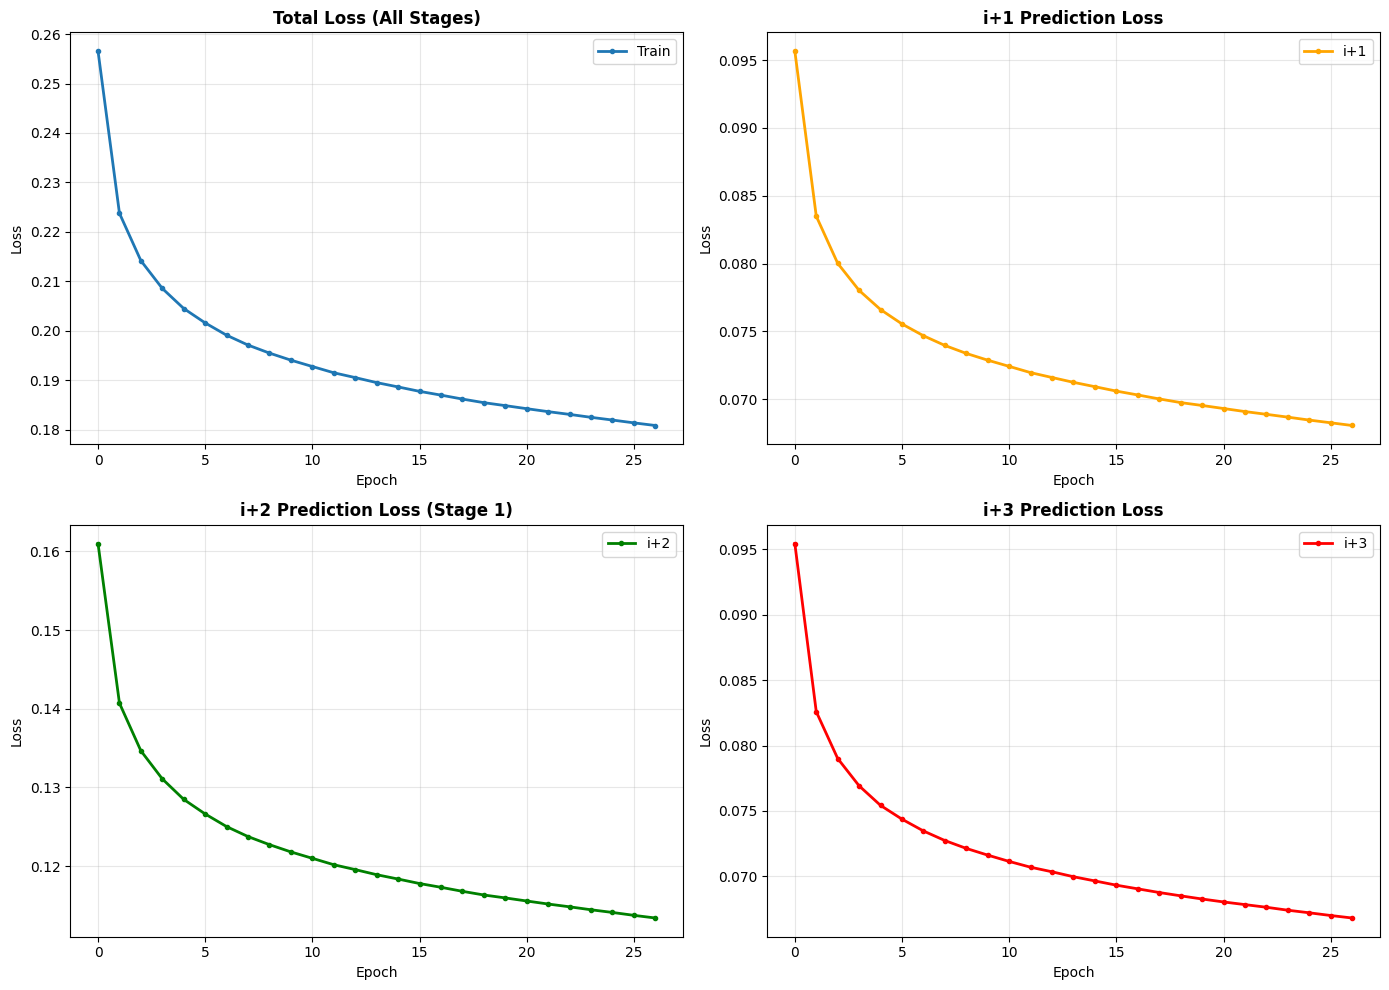

✅ Training curves saved to ../results/progressive_unet_training_curves.png
✅ Training history saved to ../results/progressive_unet_history.json

PROGRESSIVE UNet TRAINING COMPLETED SUCCESSFULLY!

Model Architecture:
   - Stage 1 (UNet1): Predicts i+2 from (i, i+4)
   - Stage 2A (UNet2): Predicts i+1 from (i, i+2_generated)
   - Stage 2B (UNet3): Predicts i+3 from (i+2_generated, i+4)

Training Summary:
   Epochs trained: 27
   Best validation loss: 0.1876
   Batch size: 4
   Learning rate: 0.0005

Test Set Performance:
   i+1 - SSIM: 0.7676 ± 0.0506, PSNR: 27.91 ± 2.27 dB
   i+2 - SSIM: 0.6353 ± 0.0738, PSNR: 24.99 ± 2.42 dB
   i+3 - SSIM: 0.7698 ± 0.0493, PSNR: 28.01 ± 2.27 dB
   Average - SSIM: 0.7242, PSNR: 26.97 dB

Loss Weights (Multi-Scale):
   w_i1 (i+1 prediction): 0.5
   w_i2 (i+2 prediction): 1.0
   w_i3 (i+3 prediction): 0.5

Files saved to: ../models


In [12]:
# Plot training curves
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Total loss
axes[0, 0].plot(train_losses['total'], linewidth=2, marker='o', markersize=3, label='Train')
axes[0, 0].set_title('Total Loss (All Stages)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# i+1 Loss
axes[0, 1].plot(train_losses['i1'], linewidth=2, marker='o', markersize=3, label='i+1', color='orange')
axes[0, 1].set_title('i+1 Prediction Loss', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# i+2 Loss
axes[1, 0].plot(train_losses['i2'], linewidth=2, marker='o', markersize=3, label='i+2', color='green')
axes[1, 0].set_title('i+2 Prediction Loss (Stage 1)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# i+3 Loss
axes[1, 1].plot(train_losses['i3'], linewidth=2, marker='o', markersize=3, label='i+3', color='red')
axes[1, 1].set_title('i+3 Prediction Loss', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plot_path = RESULTS_SAVE_DIR / 'progressive_unet_training_curves.png'
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Training curves saved to {plot_path}")

# Save training history and metrics
history = {
    'train_losses': train_losses,
    'test_metrics': {
        'i1': {'ssim_mean': float(ssim_i1.mean()), 'ssim_std': float(ssim_i1.std()),
               'psnr_mean': float(psnr_i1.mean()), 'psnr_std': float(psnr_i1.std())},
        'i2': {'ssim_mean': float(ssim_i2.mean()), 'ssim_std': float(ssim_i2.std()),
               'psnr_mean': float(psnr_i2.mean()), 'psnr_std': float(psnr_i2.std())},
        'i3': {'ssim_mean': float(ssim_i3.mean()), 'ssim_std': float(ssim_i3.std()),
               'psnr_mean': float(psnr_i3.mean()), 'psnr_std': float(psnr_i3.std())},
        'average': {'ssim': float(avg_ssim), 'psnr': float(avg_psnr)}
    },
    'config': {
        'epochs': len(train_losses['total']),
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'loss_weights': LOSS_WEIGHTS,
        'architecture': 'Progressive UNet (3-stage)',
        'stages': {
            'stage1': 'UNet(i, i+4) -> i+2',
            'stage2a': 'UNet(i, i+2_gen) -> i+1',
            'stage2b': 'UNet(i+2_gen, i+4) -> i+3'
        }
    },
    'timestamp': datetime.now().isoformat()
}

log_path = RESULTS_SAVE_DIR / 'progressive_unet_history.json'
with open(log_path, 'w') as f:
    json.dump(history, f, indent=4)

print(f"✅ Training history saved to {log_path}")

# Summary
print(f"\n" + "="*90)
print("PROGRESSIVE UNet TRAINING COMPLETED SUCCESSFULLY!")
print("="*90)
print(f"\nModel Architecture:")
print(f"   - Stage 1 (UNet1): Predicts i+2 from (i, i+4)")
print(f"   - Stage 2A (UNet2): Predicts i+1 from (i, i+2_generated)")
print(f"   - Stage 2B (UNet3): Predicts i+3 from (i+2_generated, i+4)")
print(f"\nTraining Summary:")
print(f"   Epochs trained: {len(train_losses['total'])}")
print(f"   Best validation loss: {best_val_loss:.4f}")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Learning rate: {LEARNING_RATE}")
print(f"\nTest Set Performance:")
print(f"   i+1 - SSIM: {ssim_i1.mean():.4f} ± {ssim_i1.std():.4f}, PSNR: {psnr_i1.mean():.2f} ± {psnr_i1.std():.2f} dB")
print(f"   i+2 - SSIM: {ssim_i2.mean():.4f} ± {ssim_i2.std():.4f}, PSNR: {psnr_i2.mean():.2f} ± {psnr_i2.std():.2f} dB")
print(f"   i+3 - SSIM: {ssim_i3.mean():.4f} ± {ssim_i3.std():.4f}, PSNR: {psnr_i3.mean():.2f} ± {psnr_i3.std():.2f} dB")
print(f"   Average - SSIM: {avg_ssim:.4f}, PSNR: {avg_psnr:.2f} dB")
print(f"\nLoss Weights (Multi-Scale):")
print(f"   w_i1 (i+1 prediction): {LOSS_WEIGHTS['w_i1']}")
print(f"   w_i2 (i+2 prediction): {LOSS_WEIGHTS['w_i2']}")
print(f"   w_i3 (i+3 prediction): {LOSS_WEIGHTS['w_i3']}")
print(f"\nFiles saved to: {MODEL_SAVE_DIR}")
print("="*90)
